# Related to figure 4b

In [11]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import re 
import warnings

warnings.filterwarnings("ignore")

pathans = "/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/oldans/"
expand_dir = '/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/expand_metadata_merged'

TLSlabelpath = "/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/TLS_group.1125.txt"
df_score = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Figure3/1.data/Tumor_sample_TryptophanScore.txt', index_col=0, sep='\t')
# only use tumor sample
samplelist = ["ST2772T","ST2907T","ST2893T","ST2931T","ST2976T"]

In [8]:
# functions
# reset the coordinate
def get_df_plot(df_meta):
    df_pos = df_meta[['row', 'col']]
    df_meta = df_meta.drop(['row', 'col'], axis=1)
    df_pos['row'] = df_pos['row'] - min(df_pos['row']) + 1         
    df_pos['col'] = df_pos['col'] - min(df_pos['col']) + 1

    df_pos['tmp'] = df_pos['row'].copy()
    df_pos['row'] = df_pos['col']
    df_pos['col'] = df_pos['tmp']
    df_pos = df_pos.drop('tmp', axis=1)   
    df_pos['col'] = max(df_pos['col']) + 1 - df_pos['col']

    spot_row = max(df_pos['row']) - min(df_pos['row']) + 1    
    spot_col = max(df_pos['col']) - min(df_pos['col']) + 1

    df_plot = pd.merge(df_pos, df_meta, left_index=True, right_index=True)
    return df_plot, spot_row, spot_col, df_pos


# define the TLS center
def get_tls_center_xy(df_tls,  isB=False):
    df_b = df_tls[df_tls['SpotLight_Anno'] == 'B']
    centerX, centerY = df_b[['col', 'row']].mean()
    if isB:
        all_pos = df_b[['col', 'row']].values
        min_idx = np.argmin(cdist(all_pos, [[centerX, centerY]]))
        my_center = df_b.index[min_idx]
        centerX, centerY = df_b.loc[my_center, 'col'], df_b.loc[my_center, 'row']
    return int(centerX), int(centerY)

# TLS expand function
def get_center_expand_value(df_tls, spot_col, spot_row, centerCol, centerRow):
    tls_mask = np.full((spot_col+2, spot_row+2), 0, dtype="uint8")
    tls_mask[df_tls['col'].values, df_tls['row'].values] = 255
    # cv2.imwrite('test.png', tls_mask)
    try_mask = np.full((spot_col+2, spot_row+2), np.inf)
    try_mask[df_tls['col'].values, df_tls['row'].values] = df_tls.TryptophanGene1.values
    # 从中心点往外扩
    dic_tls_circle_try = {}
    mask = np.full((spot_col+2, spot_row+2), 0, dtype="uint8")
    mask[centerCol, centerRow] = 1
    dic_tls_circle_try[0] = np.array([try_mask[centerCol, centerRow]])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  
    cur_edge = mask.copy()
    old_mask = mask.copy()
    my_circle = 0
    while np.any(cv2.bitwise_and(cur_edge, tls_mask)):
        # 记录色氨酸信号
        edgeXY = np.where(cur_edge == 1)
        cur_value = try_mask[edgeXY]
        cur_value = cur_value[cur_value!=np.inf]
        dic_tls_circle_try[my_circle] = cur_value
        my_circle += 1

        new_mask = cv2.dilate(old_mask, kernel)    # 外扩一圈
        cur_edge = new_mask - old_mask
        old_mask = new_mask
    return dic_tls_circle_try


def expand_arr(v1, num_final):
    # 插入
    if len(v1) < num_final:
        insert_num = num_final - len(v1)
        insert_pos = len(v1) - 1
        insert_per_pos = insert_num // insert_pos
        insert_per_add = insert_num % insert_pos
        my_insert_arr = [insert_per_pos] * insert_pos
        for i in range(insert_per_add):
            my_insert_arr[i] += 1
        new_arr = [v1[0]]
        for i in range(len(v1)-1):
            my_v_start = v1[i]
            my_v_end = v1[i+1]
            my_insert_num = my_insert_arr[i]
            my_new_arr = np.linspace(my_v_start,my_v_end,my_insert_num+2)[1:]
            new_arr.extend(list(my_new_arr))
        return new_arr
    elif len(v1) > num_final:
        my_merge_arr = np.linspace(0,len(v1),num_final+1)
        my_merge_arr = [int(x) for x in my_merge_arr]

        new_arr = []
        for i in range(len(my_merge_arr)-1):
            my_pos_start = my_merge_arr[i]
            my_pos_end = my_merge_arr[i+1]
            my_new_value = np.mean(v1[my_pos_start: my_pos_end])
            new_arr.append(my_new_value)
        return new_arr
    elif len(v1) == num_final:
        return v1

def smooth_yyc_v2(cur_values, windows_size=15):
    smooth_values = []
    for i in range(len(cur_values)):
        if i < windows_size//2:
            used_values = np.mean(cur_values[: i+windows_size//2 + 1])
        elif i > len(cur_values) - windows_size//2:
            used_values = np.mean(cur_values[i-windows_size//2:])
        else:
            used_values = np.mean(cur_values[i-windows_size//2: i+windows_size//2 + 1])
        smooth_values.append(used_values)
    return smooth_values

In [9]:
df_group = pd.read_csv(TLSlabelpath, index_col=0, sep='\t')
used_tls = df_group[df_group['Group'].isin(['Mature', 'NotMature'])].index
dic_all = {}
for sample in samplelist:
    df_meta = pd.read_csv(f'{pathans}{sample}_metadata_Tryptophan.txt', sep='\t',  index_col=0, low_memory=False)
    df_tmp = df_score.loc[df_score.index.str.startswith(sample), ]
    df_tmp.index = [x.split('_')[1] for x in df_tmp.index]
    df_meta['TryptophanGene1'] = df_tmp.reindex(df_meta.index)['KEGG_TRYPTOPHAN_METABOLISM']
    df_plot, spot_row, spot_col, df_pos = get_df_plot(df_meta)

    df_plot = df_plot[df_plot['TLS'] != f'{sample}_NA']
    tls_list = list(set(df_plot['TLS'].unique()) & set(used_tls))
    for tls in tls_list:
        df_tls = df_plot[df_plot['TLS'] == tls]
        centerCol, centerRow = get_tls_center_xy(df_tls, isB=False)
        dic_cur = get_center_expand_value(df_tls, spot_col, spot_row, centerCol, centerRow)
        dic_all[tls] = dic_cur


######################################## signal within TLS ###################################################
num_final = 13
dic_mature = {}
dic_immature = {}

for tls, v in dic_all.items():
    if df_group.loc[tls, 'Group'] == 'Mature':
        dic_mature[tls] = v
    else:
        dic_immature[tls] = v


df_mature = pd.DataFrame(index=range(num_final))
for tls, my_v in dic_mature.items():
    raw_arr = []
    for circle in range(len(my_v)):
        raw_arr.append(np.mean(my_v[circle]))
    new_arr = expand_arr(raw_arr, num_final)
    df_mature[tls] = new_arr

df_immature = pd.DataFrame(index=range(num_final))
for tls, my_v in dic_immature.items():
    if len(my_v) == 1:
        continue
    else:
        raw_arr = []
        for circle in range(len(my_v)):
            raw_arr.append(np.mean(my_v[circle]))
        new_arr = expand_arr(raw_arr, num_final)
        df_immature[tls] = new_arr
    

df_plot_smooth = pd.DataFrame(index=['Mature', 'Immature'], columns=df_mature.index)
df_plot_smooth.loc['Mature'] = smooth_yyc_v2(df_mature.T.mean(), windows_size=4)
df_plot_smooth.loc['Immature'] = smooth_yyc_v2(df_immature.T.mean(), windows_size=4)

df_plot_smooth

,0,1,2,3,4,5,6,7,8,9,10,11,12
Mature,-0.068216,-0.070222,-0.072481,-0.073105,-0.075243,-0.07423,-0.072143,-0.069198,-0.067971,-0.064699,-0.065806,-0.065806,-0.065478
Immature,-0.047482,-0.04962,-0.049599,-0.050979,-0.05257,-0.0514,-0.04874,-0.049024,-0.048044,-0.04527,-0.040777,-0.040287,-0.036739


In [12]:
################################################## signal outside TLS ##################################
def get_tls_expand_values(df_meta, df_score, tls, n=30):
    dic_cur = {}
    raw_bins = df_meta[df_meta['TLS'] == tls].index
    for circle in range(1, n+1):
        cur_item = f'TLS_expand_{circle}'
        new_bins = df_meta[df_meta[cur_item] == f'{tls}_Expand'].index
        edge_bins = new_bins.difference(raw_bins)
        edge_values = df_score.reindex(edge_bins)['TryptophanGene1'].values
        dic_cur[circle] = edge_values
        raw_bins = new_bins
    return dic_cur

dic_all_expand = {}
for sample in samplelist:
    df_meta = pd.read_csv(f'{expand_dir}/{sample}_metadata_TLS_expand1_30.txt', index_col=0, sep='\t')
    df_score = pd.read_csv(f'{pathans}{sample}_metadata_Tryptophan.txt', sep='\t',  index_col=0, low_memory=False)
    all_tls = df_meta.TLS.unique()
    for tls in all_tls:
        if tls in used_tls:
            dic_all_expand[tls] = get_tls_expand_values(df_meta, df_score, tls)

dic_mature_expand = {}
dic_immature_expand = {}

for tls, v in dic_all_expand.items():
    if df_group.loc[tls, 'Group'] == 'Mature':
        dic_mature_expand[tls] = v
    else:
        dic_immature_expand[tls] = v

df_mature_expand = pd.DataFrame(index=range(30))
for tls, my_v in dic_mature_expand.items():
    raw_arr = []
    for circle in range(len(my_v)):
        raw_arr.append(np.mean(my_v[circle+1]))
    df_mature_expand[tls] = raw_arr

df_immature_expand = pd.DataFrame(index=range(30))
for tls, my_v in dic_immature_expand.items():
    raw_arr = []
    for circle in range(len(my_v)):
        raw_arr.append(np.mean(my_v[circle+1]))
    df_immature_expand[tls] = raw_arr



df_plot_smooth_expand = pd.DataFrame(index=['Mature', 'Immature'], columns=df_mature_expand.index)
df_plot_smooth_expand.loc['Mature'] = smooth_yyc_v2(df_mature_expand.T.mean(), windows_size=4)
df_plot_smooth_expand.loc['Immature'] = smooth_yyc_v2(df_immature_expand.T.mean(), windows_size=4)
df_plot_smooth_expand


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Mature,-0.026622,-0.027435,-0.027067,-0.027456,-0.028393,-0.0285,-0.028568,-0.029057,-0.029058,-0.028021,...,-0.025118,-0.025304,-0.024858,-0.024771,-0.023461,-0.025393,-0.024073,-0.024632,-0.02484,-0.025455
Immature,-0.027197,-0.026655,-0.024828,-0.022238,-0.021602,-0.021091,-0.019107,-0.020569,-0.019956,-0.020307,...,-0.019706,-0.020098,-0.019964,-0.018969,-0.018807,-0.019045,-0.017899,-0.017214,-0.017235,-0.016196


In [13]:
############################ ####### merge signal within and outside TLS
df_mature_expand = df_mature_expand[df_mature.columns]
df_mature_merged = pd.concat((df_mature, df_mature_expand))
df_mature_merged.index = range(df_mature_merged.shape[0])

df_immature_expand = df_immature_expand[df_immature.columns]
df_immature_merged = pd.concat((df_immature, df_immature_expand))
df_immature_merged.index = range(df_immature_merged.shape[0])


df_plot_smooth_merged = pd.DataFrame(index=['Mature', 'Immature'], columns=df_mature_merged.index)
df_plot_smooth_merged.loc['Mature'] = smooth_yyc_v2(df_mature_merged.T.mean(), windows_size=10)
df_plot_smooth_merged.loc['Immature'] = smooth_yyc_v2(df_immature_merged.T.mean(), windows_size=10)



df_mature_merge_T = df_mature_merged.loc[:, df_mature_merged.columns.str.contains('T_')]
df_immature_merge_T = df_immature_merged.loc[:, df_immature_merged.columns.str.contains('T_')]


df_plot_smooth_merged_T_raw = pd.DataFrame(index=['Mature', 'Immature'], columns=df_mature_merged.index)
df_plot_smooth_merged_T_raw.loc['Mature'] = df_mature_merge_T.T.mean()
df_plot_smooth_merged_T_raw.loc['Immature'] = df_immature_merge_T.T.mean()


# remove the first 2 values because of high variance
df_mature_merge_T = df_mature_merge_T.iloc[2:, :]
df_immature_merge_T = df_immature_merge_T.iloc[2:, :]

df_mature_merge_T = df_mature_merge_T.iloc[:-5, :]
df_immature_merge_T = df_immature_merge_T.iloc[:-5, :]

# df_immature_merge_T = df_immature_merge_T.loc[:, ~(df_immature_merge_T.columns.str.startswith('ST2772T')) | (df_immature_merge_T.columns.str.startswith('ST2893T'))]
# df_immature_merge_T = df_immature_merge_T.loc[:, ~(df_immature_merge_T.columns.str.startswith('ST2893T'))]

df_plot_smooth_merged_T = pd.DataFrame(index=['Mature', 'Immature'], columns=df_mature_merge_T.index)
df_plot_smooth_merged_T.loc['Mature'] = smooth_yyc_v2(df_mature_merge_T.T.median(), windows_size=12)
df_plot_smooth_merged_T.loc['Immature'] = smooth_yyc_v2(df_immature_merge_T.T.median(), windows_size=12)


plot_idx = np.hstack((np.array(range(-(num_final+23), 0)), np.array(range(1, (num_final+24)))))

df_plot_smooth_merged_T = (df_plot_smooth_merged_T - df_plot_smooth_merged_T.min().min()) / (df_plot_smooth_merged_T.max().max() - df_plot_smooth_merged_T.min().min())


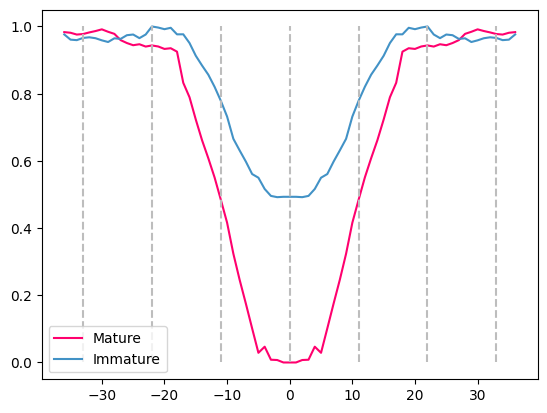

In [16]:
plt.figure()
for tls in df_plot_smooth_merged_T.index:
    cur_values = df_plot_smooth_merged_T.loc[tls].values
    new_values = cur_values[::-1]
    plot_values = np.hstack((new_values, cur_values))
    if tls.startswith('Mature'):
        plt.plot(plot_idx, plot_values, color='#FF006E', label='Mature')
    elif tls.startswith('Immature'):
        plt.plot(plot_idx, plot_values, color='#4292c6', label='Immature')
    # else:
    #     plt.plot(plot_idx, plot_values, color='#bdbdbd', label='Background')
plt.legend()
plt.vlines(11, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(22, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(33, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(0, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(-11, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(-22, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.vlines(-33, 0, 1, linestyles='dashed', colors='#bdbdbd')
plt.show()


In [33]:
df_mature_merge_T

,ST2907T_1,ST2907T_15,ST2907T_5,ST2907T_28,ST2907T_29,ST2907T_11,ST2907T_26,ST2907T_3,ST2931T_8,ST2931T_11,ST2931T_7,ST2976T_8,ST2976T_15,ST2976T_18,ST2976T_2,ST2976T_25,ST2976T_31,ST2976T_4,ST2976T_19,ST2976T_27
2,-0.128228,-0.071831,-0.122730,-0.075713,-0.105675,-0.095585,-0.064455,-0.114821,-0.068556,-0.047531,-0.010743,-0.089030,-0.085634,-0.020096,-0.112193,-0.055692,-0.078145,-0.009887,-0.077915,0.002535
3,-0.127424,-0.104040,-0.118266,-0.080142,-0.082197,-0.100050,-0.090620,-0.130162,-0.042291,-0.043782,-0.032533,-0.077242,-0.082594,-0.034452,-0.111110,-0.049177,-0.092441,-0.041595,-0.075209,-0.009487
4,-0.126620,-0.078318,-0.113802,-0.084571,-0.085661,-0.104514,-0.116785,-0.121817,-0.064852,-0.040300,-0.054323,-0.065454,-0.093198,-0.048808,-0.110027,-0.086304,-0.080345,-0.047915,-0.085214,-0.021509
5,-0.095874,-0.088465,-0.111992,-0.076024,-0.086170,-0.095630,-0.094612,-0.128996,-0.065031,-0.028059,-0.055221,-0.067338,-0.079607,-0.048776,-0.079688,-0.041052,-0.078719,-0.041077,-0.066317,-0.025791
6,-0.105703,-0.130218,-0.110708,-0.067476,-0.070942,-0.086746,-0.072439,-0.115566,-0.070190,-0.026447,-0.033633,-0.069221,-0.082943,-0.048744,-0.049350,-0.084645,-0.095394,-0.063714,-0.068606,-0.030073
7,-0.091993,-0.108630,-0.104534,-0.068961,-0.079338,-0.078915,-0.064230,-0.104167,-0.034326,-0.026950,-0.063610,-0.049097,-0.079903,-0.086174,-0.052726,-0.066037,-0.028144,-0.029744,-0.078826,-0.034355
8,-0.078023,-0.078483,-0.122184,-0.070447,-0.083759,-0.071084,-0.056021,-0.112010,-0.051098,-0.002725,-0.053953,-0.066616,-0.089420,-0.065695,-0.056102,-0.037271,-0.089751,-0.016372,-0.076453,-0.038637
9,-0.071642,-0.152877,-0.111558,-0.072887,-0.086689,-0.072902,-0.090639,-0.105105,-0.049761,-0.032733,-0.030398,-0.053146,-0.079029,-0.021867,-0.073959,-0.075961,-0.050222,-0.033157,-0.037485,-0.033841
10,-0.078923,-0.115933,-0.095872,-0.016749,-0.080209,-0.074720,-0.085428,-0.108744,-0.092266,-0.048433,-0.074245,-0.031362,-0.079362,-0.053079,-0.031157,-0.075299,-0.062480,-0.068698,-0.029762,-0.029045
11,-0.053716,-0.038599,-0.061256,-0.050846,-0.090616,-0.107402,-0.066400,-0.115950,-0.029352,0.000723,-0.037932,-0.062401,-0.078680,-0.050897,-0.031477,-0.004145,-0.127394,-0.056318,-0.068636,-0.024248


In [49]:
################################ statistic
from scipy.stats import ttest_ind
from scipy.stats import ranksums
from scipy.stats import kstest



# p value within 0 - 11 circles
circle = 11
mature_value = []
immature_value = []
for tls in df_mature_merge_T.columns:
    for n_circle in dic_mature[tls].keys():
        cur_values = dic_mature[tls][n_circle]
        mature_value.extend(list(cur_values))
for tls in df_immature_merge_T.columns:
    if circle in dic_immature[tls]:
        for n_circle in dic_immature[tls].keys():
            cur_values = dic_immature[tls][circle]
            immature_value.extend(list(cur_values))
print('p value within 0 - 11 circles:')
print(ranksums(mature_value, immature_value))

p value within 0 - 11 circles:
RanksumsResult(statistic=-11.133552828536807, pvalue=8.613260422403806e-29)


In [48]:
# 11 - 22
mature_value = []
immature_value = []
for tls in df_mature_merge_T.columns:
    for n in range(1, 12):
        cur_values = dic_mature_expand[tls][n]
        mature_value.extend(list(cur_values))
for tls in df_immature_merge_T.columns:
    for n in range(1, 12):
        cur_values = dic_immature_expand[tls][n]
        immature_value.extend(list(cur_values))
print('p value within 11 - 22 circles:')
print(ttest_ind(mature_value, immature_value))


p value within 11 - 22 circles
Ttest_indResult(statistic=-5.552354356671659, pvalue=2.8505218367479864e-08)


In [50]:
# 22 - 33
mature_value = []
immature_value = []
for tls in df_mature_merge_T.columns:
    for n in range(12, 23):
        cur_values = dic_mature_expand[tls][n]
        mature_value.extend(list(cur_values))
for tls in df_immature_merge_T.columns:
    for n in range(12, 23):
        cur_values = dic_immature_expand[tls][n]
        immature_value.extend(list(cur_values))
print('p value within 22 - 33 circles:')
print(ttest_ind(mature_value, immature_value))

p value within 22 - 33 circles:
Ttest_indResult(statistic=-1.8670127866105397, pvalue=0.061911243878813416)
